In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV

In [16]:
def report_performance(actual,pred,predict_proba=None):
    print(f"Accuracy: {accuracy_score(actual,pred):.4f}, F1: {f1_score(actual,pred):.4f}")
    print(f"Precision: {precision_score(actual,pred):.4f}, Recall: {recall_score(actual,pred):.4f}")
    if predict_proba:
        print(f"ROC AUC: {roc_auc_score(actual,predict_proba)}")
    print(f"Confusion Matrix:\n{confusion_matrix(actual,pred)}")

In [17]:
df = pd.read_csv('parsed_games.csv')

In [18]:
len(df)

3825377

In [19]:
df.columns

Index(['total_moves', 'time_control', 'white_win', 'white_elo', 'black_elo',
       'eco', 'white_castles', 'black_castles',
       'white_total_left_wing_pawn_moves', 'white_total_center_pawn_moves',
       'white_total_right_wing_pawn_moves', 'white_total_knight_moves',
       'white_total_bishop_moves', 'white_total_rook_moves',
       'white_total_queen_moves', 'white_total_king_moves',
       'black_total_left_wing_pawn_moves', 'black_total_center_pawn_moves',
       'black_total_right_wing_pawn_moves', 'black_total_knight_moves',
       'black_total_bishop_moves', 'black_total_rook_moves',
       'black_total_queen_moves', 'black_total_king_moves',
       'white_doubled_pawn_files', 'black_doubled_pawn_files',
       'white_no_pawn_files', 'black_no_pawn_files',
       'white_total_isolated_pawn_files', 'black_total_isolated_pawn_files',
       'white_total_pawns', 'white_total_knights', 'white_total_bishops',
       'white_total_rooks', 'white_total_queens', 'black_total_pawns',

In [20]:
df['white_castles'].unique(),df['black_castles'].unique()

(array(['kingside', 'x', 'queenside'], dtype=object),
 array(['x', 'kingside', 'queenside'], dtype=object))

In [21]:
df = pd.get_dummies(df.dropna(), columns=['white_castles','black_castles','time_control'])

In [22]:
df['baseline_prediction'] = (df['white_elo'] >= df['black_elo']).astype(int)

In [31]:
df['rating_diff'] = df['white_elo'] - df['black_elo']

In [23]:
df.columns

Index(['total_moves', 'white_win', 'white_elo', 'black_elo', 'eco',
       'white_total_left_wing_pawn_moves', 'white_total_center_pawn_moves',
       'white_total_right_wing_pawn_moves', 'white_total_knight_moves',
       'white_total_bishop_moves', 'white_total_rook_moves',
       'white_total_queen_moves', 'white_total_king_moves',
       'black_total_left_wing_pawn_moves', 'black_total_center_pawn_moves',
       'black_total_right_wing_pawn_moves', 'black_total_knight_moves',
       'black_total_bishop_moves', 'black_total_rook_moves',
       'black_total_queen_moves', 'black_total_king_moves',
       'white_doubled_pawn_files', 'black_doubled_pawn_files',
       'white_no_pawn_files', 'black_no_pawn_files',
       'white_total_isolated_pawn_files', 'black_total_isolated_pawn_files',
       'white_total_pawns', 'white_total_knights', 'white_total_bishops',
       'white_total_rooks', 'white_total_queens', 'black_total_pawns',
       'black_total_knights', 'black_total_bishops', 'bl

In [24]:
report_performance(df['white_win'],df['baseline_prediction'])

Accuracy: 0.6486, F1: 0.6483
Precision: 0.6502, Recall: 0.6464
Confusion Matrix:
[[1238713  664638]
 [ 675549 1235145]]


In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    df.dropna().drop('white_win',axis=1),
    df.dropna()['white_win'],
    test_size = 0.2,
    random_state = 1
)

In [34]:
drop1 = ['total_moves', 'white_elo', 'black_elo', 'eco', 'baseline_prediction']
X_train1 = X_train.drop(drop1,axis=1).astype(np.int64)
X_test1 = X_test.drop(drop1,axis=1).astype(np.int64)

In [35]:
X_train1.columns

Index(['white_total_left_wing_pawn_moves', 'white_total_center_pawn_moves',
       'white_total_right_wing_pawn_moves', 'white_total_knight_moves',
       'white_total_bishop_moves', 'white_total_rook_moves',
       'white_total_queen_moves', 'white_total_king_moves',
       'black_total_left_wing_pawn_moves', 'black_total_center_pawn_moves',
       'black_total_right_wing_pawn_moves', 'black_total_knight_moves',
       'black_total_bishop_moves', 'black_total_rook_moves',
       'black_total_queen_moves', 'black_total_king_moves',
       'white_doubled_pawn_files', 'black_doubled_pawn_files',
       'white_no_pawn_files', 'black_no_pawn_files',
       'white_total_isolated_pawn_files', 'black_total_isolated_pawn_files',
       'white_total_pawns', 'white_total_knights', 'white_total_bishops',
       'white_total_rooks', 'white_total_queens', 'black_total_pawns',
       'black_total_knights', 'black_total_bishops', 'black_total_rooks',
       'black_total_queens', 'white_total_attacked

In [127]:
xgb_model1 = xgb.XGBClassifier(n_estimators=1000,early_stopping_rounds=50)
xgb_model1.fit(X_train1,y_train,
              eval_set=[(X_train1,y_train),(X_test1,y_test)],
              verbose=True
             )
xgb_pred1 = pd.Series(xgb_model1.predict(X_test1))
report_performance(y_test,xgb_pred1)

[0]	validation_0-logloss:0.67912	validation_1-logloss:0.67917
[1]	validation_0-logloss:0.67087	validation_1-logloss:0.67100
[2]	validation_0-logloss:0.66517	validation_1-logloss:0.66533
[3]	validation_0-logloss:0.66153	validation_1-logloss:0.66175
[4]	validation_0-logloss:0.65841	validation_1-logloss:0.65863
[5]	validation_0-logloss:0.65607	validation_1-logloss:0.65631
[6]	validation_0-logloss:0.65336	validation_1-logloss:0.65365
[7]	validation_0-logloss:0.65162	validation_1-logloss:0.65197
[8]	validation_0-logloss:0.64942	validation_1-logloss:0.64975
[9]	validation_0-logloss:0.64797	validation_1-logloss:0.64835
[10]	validation_0-logloss:0.64703	validation_1-logloss:0.64742
[11]	validation_0-logloss:0.64575	validation_1-logloss:0.64613
[12]	validation_0-logloss:0.64460	validation_1-logloss:0.64504
[13]	validation_0-logloss:0.64367	validation_1-logloss:0.64410
[14]	validation_0-logloss:0.64301	validation_1-logloss:0.64346
[15]	validation_0-logloss:0.64246	validation_1-logloss:0.64292
[1

[130]	validation_0-logloss:0.62960	validation_1-logloss:0.63386
[131]	validation_0-logloss:0.62953	validation_1-logloss:0.63383
[132]	validation_0-logloss:0.62951	validation_1-logloss:0.63383
[133]	validation_0-logloss:0.62947	validation_1-logloss:0.63382
[134]	validation_0-logloss:0.62943	validation_1-logloss:0.63380
[135]	validation_0-logloss:0.62940	validation_1-logloss:0.63379
[136]	validation_0-logloss:0.62936	validation_1-logloss:0.63379
[137]	validation_0-logloss:0.62933	validation_1-logloss:0.63379
[138]	validation_0-logloss:0.62930	validation_1-logloss:0.63378
[139]	validation_0-logloss:0.62926	validation_1-logloss:0.63378
[140]	validation_0-logloss:0.62923	validation_1-logloss:0.63378
[141]	validation_0-logloss:0.62920	validation_1-logloss:0.63377
[142]	validation_0-logloss:0.62916	validation_1-logloss:0.63377
[143]	validation_0-logloss:0.62912	validation_1-logloss:0.63377
[144]	validation_0-logloss:0.62908	validation_1-logloss:0.63376
[145]	validation_0-logloss:0.62905	valid

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

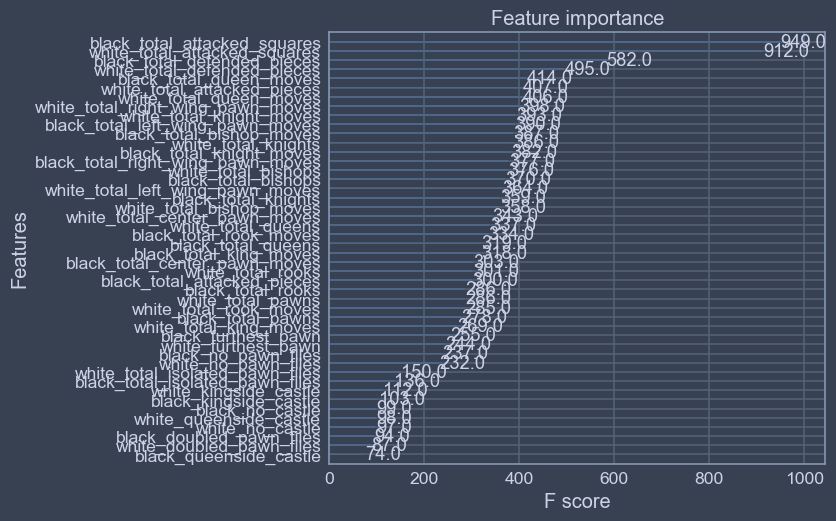

In [131]:
xgb.plot_importance(xgb_model1)

In [128]:
drop2 = ['total_moves', 'eco', 'white_castles', 'black_castles', 'baseline_prediction']
X_train2 = X_train.drop(drop2,axis=1).astype(np.int64)
X_test2 = X_test.drop(drop2,axis=1).astype(np.int64)

In [129]:
X_train2.columns

Index(['white_elo', 'black_elo', 'white_total_left_wing_pawn_moves',
       'white_total_center_pawn_moves', 'white_total_right_wing_pawn_moves',
       'white_total_knight_moves', 'white_total_bishop_moves',
       'white_total_rook_moves', 'white_total_queen_moves',
       'white_total_king_moves', 'black_total_left_wing_pawn_moves',
       'black_total_center_pawn_moves', 'black_total_right_wing_pawn_moves',
       'black_total_knight_moves', 'black_total_bishop_moves',
       'black_total_rook_moves', 'black_total_queen_moves',
       'black_total_king_moves', 'white_doubled_pawn_files',
       'black_doubled_pawn_files', 'white_no_pawn_files',
       'black_no_pawn_files', 'white_total_isolated_pawn_files',
       'black_total_isolated_pawn_files', 'white_total_pawns',
       'white_total_knights', 'white_total_bishops', 'white_total_rooks',
       'white_total_queens', 'black_total_pawns', 'black_total_knights',
       'black_total_bishops', 'black_total_rooks', 'black_total_quee

In [130]:
xgb_model2 = xgb.XGBClassifier(n_estimators=1000,early_stopping_rounds=50)
xgb_model2.fit(X_train2,y_train,
              eval_set=[(X_train2,y_train),(X_test2,y_test)],
              verbose=True
             )
xgb_pred2 = pd.Series(xgb_model2.predict(X_test2))
report_performance(y_test,xgb_pred2)

[0]	validation_0-logloss:0.66382	validation_1-logloss:0.66388
[1]	validation_0-logloss:0.64594	validation_1-logloss:0.64600
[2]	validation_0-logloss:0.63464	validation_1-logloss:0.63491
[3]	validation_0-logloss:0.62652	validation_1-logloss:0.62681
[4]	validation_0-logloss:0.61783	validation_1-logloss:0.61813
[5]	validation_0-logloss:0.61364	validation_1-logloss:0.61400
[6]	validation_0-logloss:0.60901	validation_1-logloss:0.60942
[7]	validation_0-logloss:0.60634	validation_1-logloss:0.60677
[8]	validation_0-logloss:0.60347	validation_1-logloss:0.60398
[9]	validation_0-logloss:0.60119	validation_1-logloss:0.60171
[10]	validation_0-logloss:0.59933	validation_1-logloss:0.59985
[11]	validation_0-logloss:0.59750	validation_1-logloss:0.59808
[12]	validation_0-logloss:0.59595	validation_1-logloss:0.59654
[13]	validation_0-logloss:0.59422	validation_1-logloss:0.59484
[14]	validation_0-logloss:0.59302	validation_1-logloss:0.59364
[15]	validation_0-logloss:0.59202	validation_1-logloss:0.59267
[1

[130]	validation_0-logloss:0.57595	validation_1-logloss:0.58060
[131]	validation_0-logloss:0.57592	validation_1-logloss:0.58059
[132]	validation_0-logloss:0.57589	validation_1-logloss:0.58059
[133]	validation_0-logloss:0.57584	validation_1-logloss:0.58057
[134]	validation_0-logloss:0.57580	validation_1-logloss:0.58057
[135]	validation_0-logloss:0.57576	validation_1-logloss:0.58057
[136]	validation_0-logloss:0.57572	validation_1-logloss:0.58056
[137]	validation_0-logloss:0.57568	validation_1-logloss:0.58055
[138]	validation_0-logloss:0.57565	validation_1-logloss:0.58055
[139]	validation_0-logloss:0.57561	validation_1-logloss:0.58055
[140]	validation_0-logloss:0.57557	validation_1-logloss:0.58054
[141]	validation_0-logloss:0.57554	validation_1-logloss:0.58055
[142]	validation_0-logloss:0.57551	validation_1-logloss:0.58056
[143]	validation_0-logloss:0.57548	validation_1-logloss:0.58056
[144]	validation_0-logloss:0.57544	validation_1-logloss:0.58056
[145]	validation_0-logloss:0.57541	valid

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

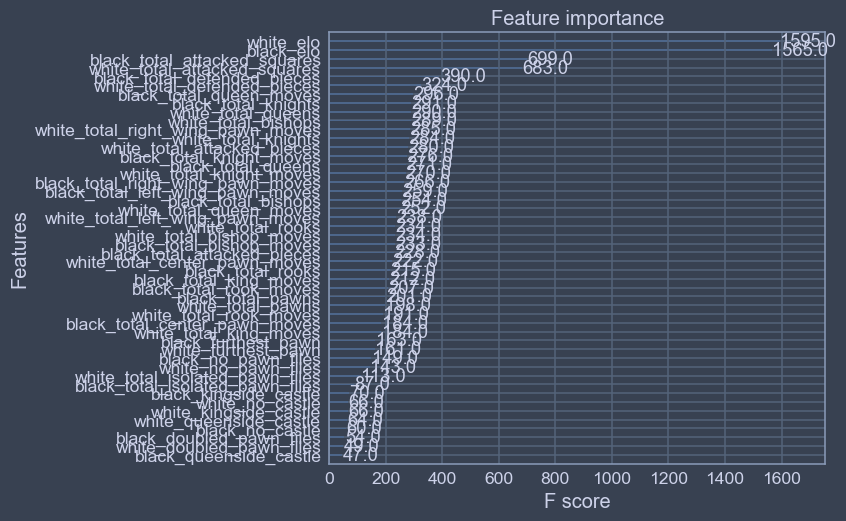

In [132]:
xgb.plot_importance(xgb_model2)

In [13]:
drop2 = ['total_moves', 'eco', 'baseline_prediction']
X_train3 = X_train.drop(drop2,axis=1).astype(np.int64)
X_train3['rating_diff'] = X_train3['white_elo'] - X_train3['black_elo']
X_test3 = X_test.drop(drop2,axis=1).astype(np.int64)
X_test3['rating_diff'] = X_test3['white_elo'] - X_test3['black_elo']
X_train3.drop(['white_elo','black_elo'],axis=1,inplace=True)
X_test3.drop(['white_elo','black_elo'],axis=1,inplace=True)

In [14]:
X_train3.columns

Index(['white_total_left_wing_pawn_moves', 'white_total_center_pawn_moves',
       'white_total_right_wing_pawn_moves', 'white_total_knight_moves',
       'white_total_bishop_moves', 'white_total_rook_moves',
       'white_total_queen_moves', 'white_total_king_moves',
       'black_total_left_wing_pawn_moves', 'black_total_center_pawn_moves',
       'black_total_right_wing_pawn_moves', 'black_total_knight_moves',
       'black_total_bishop_moves', 'black_total_rook_moves',
       'black_total_queen_moves', 'black_total_king_moves',
       'white_doubled_pawn_files', 'black_doubled_pawn_files',
       'white_no_pawn_files', 'black_no_pawn_files',
       'white_total_isolated_pawn_files', 'black_total_isolated_pawn_files',
       'white_total_pawns', 'white_total_knights', 'white_total_bishops',
       'white_total_rooks', 'white_total_queens', 'black_total_pawns',
       'black_total_knights', 'black_total_bishops', 'black_total_rooks',
       'black_total_queens', 'white_total_attacked

In [207]:
xgb_model3 = xgb.XGBClassifier(n_estimators=1000,early_stopping_rounds=50)
xgb_model3.fit(X_train3,y_train,
              eval_set=[(X_train3,y_train),(X_test3,y_test)],
              verbose=True
             )
xgb_pred3 = pd.Series(xgb_model3.predict(X_test3))
report_performance(y_test,xgb_pred3)

[0]	validation_0-logloss:0.65326	validation_1-logloss:0.65339
[1]	validation_0-logloss:0.63142	validation_1-logloss:0.63167
[2]	validation_0-logloss:0.61876	validation_1-logloss:0.61910
[3]	validation_0-logloss:0.61105	validation_1-logloss:0.61149
[4]	validation_0-logloss:0.60530	validation_1-logloss:0.60581
[5]	validation_0-logloss:0.60189	validation_1-logloss:0.60246
[6]	validation_0-logloss:0.59918	validation_1-logloss:0.59981
[7]	validation_0-logloss:0.59579	validation_1-logloss:0.59646
[8]	validation_0-logloss:0.59438	validation_1-logloss:0.59509
[9]	validation_0-logloss:0.59297	validation_1-logloss:0.59376
[10]	validation_0-logloss:0.59148	validation_1-logloss:0.59229
[11]	validation_0-logloss:0.58976	validation_1-logloss:0.59062
[12]	validation_0-logloss:0.58847	validation_1-logloss:0.58935
[13]	validation_0-logloss:0.58758	validation_1-logloss:0.58850
[14]	validation_0-logloss:0.58617	validation_1-logloss:0.58709
[15]	validation_0-logloss:0.58514	validation_1-logloss:0.58608
[1

[130]	validation_0-logloss:0.56978	validation_1-logloss:0.57465
[131]	validation_0-logloss:0.56973	validation_1-logloss:0.57464
[132]	validation_0-logloss:0.56970	validation_1-logloss:0.57464
[133]	validation_0-logloss:0.56966	validation_1-logloss:0.57463
[134]	validation_0-logloss:0.56962	validation_1-logloss:0.57462
[135]	validation_0-logloss:0.56958	validation_1-logloss:0.57461
[136]	validation_0-logloss:0.56955	validation_1-logloss:0.57460
[137]	validation_0-logloss:0.56951	validation_1-logloss:0.57459
[138]	validation_0-logloss:0.56947	validation_1-logloss:0.57459
[139]	validation_0-logloss:0.56944	validation_1-logloss:0.57458
[140]	validation_0-logloss:0.56941	validation_1-logloss:0.57458
[141]	validation_0-logloss:0.56937	validation_1-logloss:0.57457
[142]	validation_0-logloss:0.56933	validation_1-logloss:0.57457
[143]	validation_0-logloss:0.56928	validation_1-logloss:0.57456
[144]	validation_0-logloss:0.56923	validation_1-logloss:0.57456
[145]	validation_0-logloss:0.56919	valid

[259]	validation_0-logloss:0.56557	validation_1-logloss:0.57441
[260]	validation_0-logloss:0.56554	validation_1-logloss:0.57441
[261]	validation_0-logloss:0.56552	validation_1-logloss:0.57441
[262]	validation_0-logloss:0.56549	validation_1-logloss:0.57441
[263]	validation_0-logloss:0.56546	validation_1-logloss:0.57441
[264]	validation_0-logloss:0.56543	validation_1-logloss:0.57442
[265]	validation_0-logloss:0.56540	validation_1-logloss:0.57442
[266]	validation_0-logloss:0.56538	validation_1-logloss:0.57442
[267]	validation_0-logloss:0.56535	validation_1-logloss:0.57442
[268]	validation_0-logloss:0.56532	validation_1-logloss:0.57442
[269]	validation_0-logloss:0.56528	validation_1-logloss:0.57442
[270]	validation_0-logloss:0.56526	validation_1-logloss:0.57442
[271]	validation_0-logloss:0.56523	validation_1-logloss:0.57441
[272]	validation_0-logloss:0.56520	validation_1-logloss:0.57441
Accuracy: 0.69, F1: 0.69
Precision: 0.69, Recall: 0.69
Confusion Matrix:
[[261433 119033]
 [116799 26554

In [210]:
xgb_pred3 = pd.Series(xgb_model3.predict(X_test3))
report_performance(y_test,xgb_pred3)

Accuracy: 0.6908, F1: 0.6925
Precision: 0.6905, Recall: 0.6945
Confusion Matrix:
[[261433 119033]
 [116799 265544]]


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

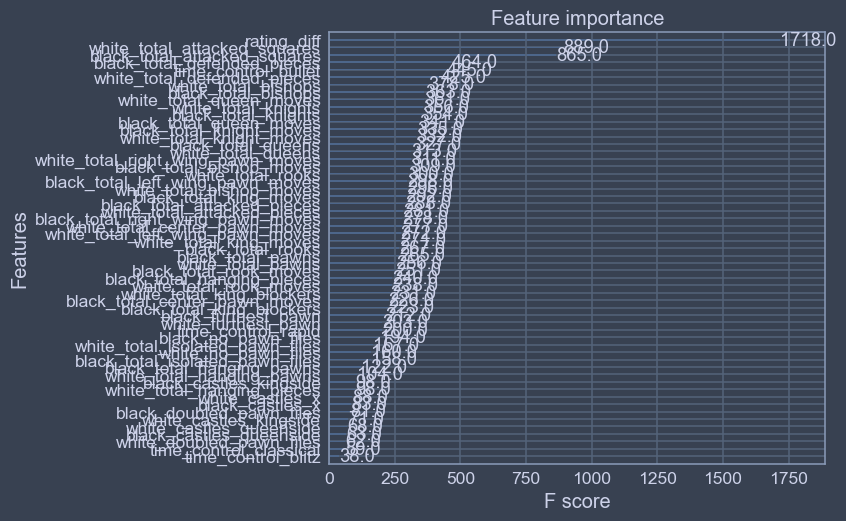

In [208]:
xgb.plot_importance(xgb_model3)

In [147]:
drop2 = ['total_moves', 'eco', 'white_castles', 'black_castles', 'baseline_prediction']
X_train4 = X_train.drop(drop2,axis=1).astype(np.int64)
X_train4['rating_ratio'] = X_train4['white_elo'] / X_train4['black_elo']
X_test4 = X_test.drop(drop2,axis=1).astype(np.int64)
X_test4['rating_ratio'] = X_test4['white_elo'] / X_test4['black_elo']
X_train4.drop(['white_elo','black_elo'],axis=1,inplace=True)
X_test4.drop(['white_elo','black_elo'],axis=1,inplace=True)

In [148]:
X_train4.columns

Index(['white_total_left_wing_pawn_moves', 'white_total_center_pawn_moves',
       'white_total_right_wing_pawn_moves', 'white_total_knight_moves',
       'white_total_bishop_moves', 'white_total_rook_moves',
       'white_total_queen_moves', 'white_total_king_moves',
       'black_total_left_wing_pawn_moves', 'black_total_center_pawn_moves',
       'black_total_right_wing_pawn_moves', 'black_total_knight_moves',
       'black_total_bishop_moves', 'black_total_rook_moves',
       'black_total_queen_moves', 'black_total_king_moves',
       'white_doubled_pawn_files', 'black_doubled_pawn_files',
       'white_no_pawn_files', 'black_no_pawn_files',
       'white_total_isolated_pawn_files', 'black_total_isolated_pawn_files',
       'white_total_pawns', 'white_total_knights', 'white_total_bishops',
       'white_total_rooks', 'white_total_queens', 'black_total_pawns',
       'black_total_knights', 'black_total_bishops', 'black_total_rooks',
       'black_total_queens', 'white_total_attacked

In [149]:
xgb_model4 = xgb.XGBClassifier(n_estimators=1000,early_stopping_rounds=50)
xgb_model4.fit(X_train4,y_train,
              eval_set=[(X_train4,y_train),(X_test4,y_test)],
              verbose=True
             )
xgb_pred4 = pd.Series(xgb_model4.predict(X_test4))
report_performance(y_test,xgb_pred4)

[0]	validation_0-logloss:0.65373	validation_1-logloss:0.65373
[1]	validation_0-logloss:0.63229	validation_1-logloss:0.63229
[2]	validation_0-logloss:0.61992	validation_1-logloss:0.61998
[3]	validation_0-logloss:0.61166	validation_1-logloss:0.61174
[4]	validation_0-logloss:0.60640	validation_1-logloss:0.60650
[5]	validation_0-logloss:0.60272	validation_1-logloss:0.60278
[6]	validation_0-logloss:0.60038	validation_1-logloss:0.60048
[7]	validation_0-logloss:0.59849	validation_1-logloss:0.59864
[8]	validation_0-logloss:0.59681	validation_1-logloss:0.59696
[9]	validation_0-logloss:0.59466	validation_1-logloss:0.59481
[10]	validation_0-logloss:0.59336	validation_1-logloss:0.59354
[11]	validation_0-logloss:0.59215	validation_1-logloss:0.59237
[12]	validation_0-logloss:0.59087	validation_1-logloss:0.59114
[13]	validation_0-logloss:0.58980	validation_1-logloss:0.59008
[14]	validation_0-logloss:0.58913	validation_1-logloss:0.58945
[15]	validation_0-logloss:0.58854	validation_1-logloss:0.58888
[1

[130]	validation_0-logloss:0.57714	validation_1-logloss:0.58147
[131]	validation_0-logloss:0.57712	validation_1-logloss:0.58146
[132]	validation_0-logloss:0.57708	validation_1-logloss:0.58145
[133]	validation_0-logloss:0.57705	validation_1-logloss:0.58145
[134]	validation_0-logloss:0.57702	validation_1-logloss:0.58145
[135]	validation_0-logloss:0.57697	validation_1-logloss:0.58144
[136]	validation_0-logloss:0.57694	validation_1-logloss:0.58144
[137]	validation_0-logloss:0.57691	validation_1-logloss:0.58144
[138]	validation_0-logloss:0.57687	validation_1-logloss:0.58143
[139]	validation_0-logloss:0.57683	validation_1-logloss:0.58142
[140]	validation_0-logloss:0.57679	validation_1-logloss:0.58143
[141]	validation_0-logloss:0.57675	validation_1-logloss:0.58143
[142]	validation_0-logloss:0.57671	validation_1-logloss:0.58142
[143]	validation_0-logloss:0.57668	validation_1-logloss:0.58142
[144]	validation_0-logloss:0.57665	validation_1-logloss:0.58142
[145]	validation_0-logloss:0.57662	valid

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

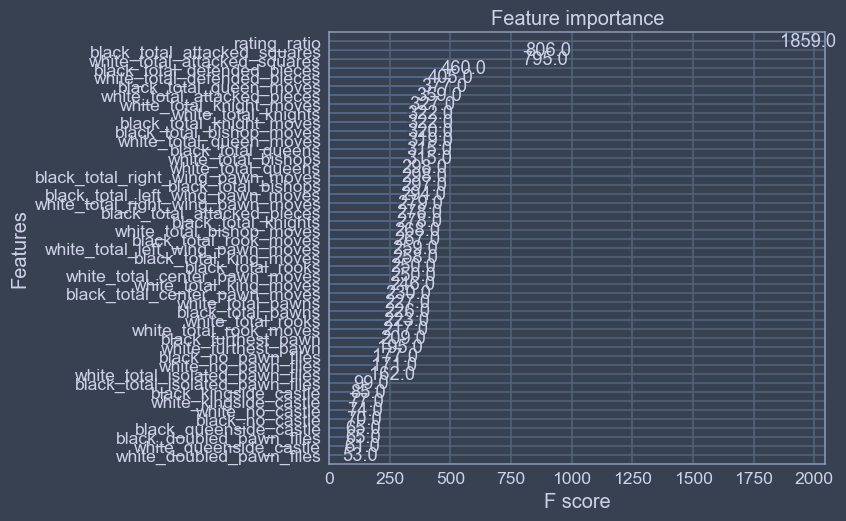

In [150]:
xgb.plot_importance(xgb_model4)

In [155]:
drop2 = ['total_moves', 'eco', 'white_castles', 'black_castles', 'baseline_prediction']
X_train5 = X_train.drop(drop2,axis=1).astype(np.int64)
X_train5['rating_ratio'] = X_train5['white_elo'] / X_train5['black_elo']
X_train5['rating_diff'] = X_train5['white_elo'] - X_train5['black_elo']
X_test5 = X_test.drop(drop2,axis=1).astype(np.int64)
X_test5['rating_ratio'] = X_test5['white_elo'] / X_test5['black_elo']
X_test5['rating_diff'] = X_test5['white_elo'] - X_test5['black_elo']
X_train5.drop(['white_elo','black_elo'],axis=1,inplace=True)
X_test5.drop(['white_elo','black_elo'],axis=1,inplace=True)

In [156]:
xgb_model5 = xgb.XGBClassifier(n_estimators=1000,early_stopping_rounds=50)
xgb_model5.fit(X_train5,y_train,
              eval_set=[(X_train5,y_train),(X_test5,y_test)],
              verbose=True
             )
xgb_pred5 = pd.Series(xgb_model5.predict(X_test5))
report_performance(y_test,xgb_pred5)

[0]	validation_0-logloss:0.65336	validation_1-logloss:0.65330
[1]	validation_0-logloss:0.63152	validation_1-logloss:0.63152
[2]	validation_0-logloss:0.61877	validation_1-logloss:0.61878
[3]	validation_0-logloss:0.61102	validation_1-logloss:0.61103
[4]	validation_0-logloss:0.60604	validation_1-logloss:0.60612
[5]	validation_0-logloss:0.60223	validation_1-logloss:0.60232
[6]	validation_0-logloss:0.59939	validation_1-logloss:0.59949
[7]	validation_0-logloss:0.59721	validation_1-logloss:0.59734
[8]	validation_0-logloss:0.59528	validation_1-logloss:0.59549
[9]	validation_0-logloss:0.59384	validation_1-logloss:0.59405
[10]	validation_0-logloss:0.59266	validation_1-logloss:0.59288
[11]	validation_0-logloss:0.59121	validation_1-logloss:0.59141
[12]	validation_0-logloss:0.59009	validation_1-logloss:0.59033
[13]	validation_0-logloss:0.58931	validation_1-logloss:0.58960
[14]	validation_0-logloss:0.58841	validation_1-logloss:0.58873
[15]	validation_0-logloss:0.58773	validation_1-logloss:0.58809
[1

[130]	validation_0-logloss:0.57582	validation_1-logloss:0.58026
[131]	validation_0-logloss:0.57580	validation_1-logloss:0.58026
[132]	validation_0-logloss:0.57576	validation_1-logloss:0.58026
[133]	validation_0-logloss:0.57573	validation_1-logloss:0.58025
[134]	validation_0-logloss:0.57572	validation_1-logloss:0.58025
[135]	validation_0-logloss:0.57569	validation_1-logloss:0.58024
[136]	validation_0-logloss:0.57564	validation_1-logloss:0.58023
[137]	validation_0-logloss:0.57561	validation_1-logloss:0.58022
[138]	validation_0-logloss:0.57558	validation_1-logloss:0.58021
[139]	validation_0-logloss:0.57555	validation_1-logloss:0.58021
[140]	validation_0-logloss:0.57552	validation_1-logloss:0.58021
[141]	validation_0-logloss:0.57549	validation_1-logloss:0.58020
[142]	validation_0-logloss:0.57546	validation_1-logloss:0.58020
[143]	validation_0-logloss:0.57541	validation_1-logloss:0.58019
[144]	validation_0-logloss:0.57539	validation_1-logloss:0.58019
[145]	validation_0-logloss:0.57537	valid

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

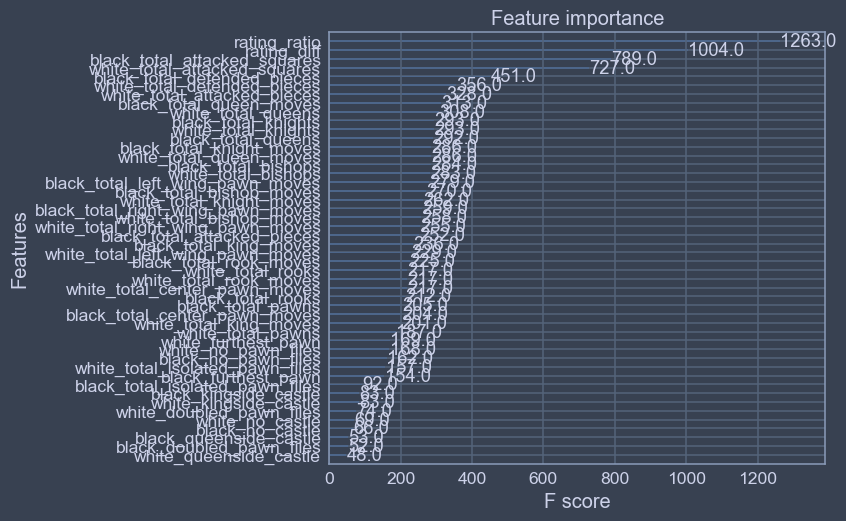

In [157]:
xgb.plot_importance(xgb_model5)

In [109]:
df2 = pd.get_dummies(df,columns=['eco'])

In [110]:
df2

,total_moves,white_win,white_elo,black_elo,white_castles,black_castles,white_total_left_wing_pawn_moves,white_total_center_pawn_moves,white_total_right_wing_pawn_moves,white_total_knight_moves,...,eco_E90,eco_E91,eco_E92,eco_E93,eco_E94,eco_E95,eco_E96,eco_E97,eco_E98,eco_E99
0,77,1,2044,2124,kingside,x,1,4,3,4,...,0,0,0,0,0,0,0,0,0,0
1,55,1,1677,1736,kingside,x,2,3,0,3,...,0,0,0,0,0,0,0,0,0,0
2,54,0,1905,1949,kingside,kingside,1,2,4,3,...,0,0,0,0,0,0,0,0,0,0
3,92,0,1726,1702,kingside,kingside,4,2,1,5,...,0,0,0,0,0,0,0,0,0,0
4,119,1,1674,1627,kingside,kingside,2,4,2,5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825372,101,1,2008,1963,kingside,kingside,2,4,4,2,...,0,0,0,0,0,0,0,0,0,0
3825373,97,1,2249,1999,queenside,queenside,4,3,4,2,...,0,0,0,0,0,0,0,0,0,0
3825374,59,1,1767,1171,kingside,kingside,1,2,0,9,...,0,0,0,0,0,0,0,0,0,0
3825375,81,1,1521,1785,kingside,kingside,2,6,2,4,...,0,0,0,0,0,0,0,0,0,0


In [112]:
X_train_eco, X_test_eco, y_train_eco, y_test_eco = train_test_split(
    df2.dropna().drop('white_win',axis=1),
    df2.dropna()['white_win'],
    test_size = 0.2,
    random_state = 1
)
drop2 = ['total_moves', 'white_castles', 'black_castles']
X_train2_eco = X_train_eco.drop(drop2,axis=1).astype(np.int64)
X_test2_eco = X_test_eco.drop(drop2,axis=1).astype(np.int64)

In [113]:
xgb_model2_eco = xgb.XGBClassifier(n_estimators=1000,early_stopping_rounds=50)
xgb_model2_eco.fit(X_train2_eco,y_train_eco,
              eval_set=[(X_train2_eco,y_train_eco),(X_test2_eco,y_test_eco)],
              verbose=True
             )
xgb_pred2_eco = pd.Series(xgb_model2_eco.predict(X_test2_eco))
report_performance(y_test_eco,xgb_pred2_eco)

[0]	validation_0-logloss:0.66159	validation_1-logloss:0.66145
[1]	validation_0-logloss:0.64398	validation_1-logloss:0.64382
[2]	validation_0-logloss:0.63268	validation_1-logloss:0.63258
[3]	validation_0-logloss:0.62481	validation_1-logloss:0.62468
[4]	validation_0-logloss:0.61703	validation_1-logloss:0.61694
[5]	validation_0-logloss:0.61331	validation_1-logloss:0.61333
[6]	validation_0-logloss:0.60888	validation_1-logloss:0.60904
[7]	validation_0-logloss:0.60527	validation_1-logloss:0.60547
[8]	validation_0-logloss:0.60359	validation_1-logloss:0.60390
[9]	validation_0-logloss:0.60136	validation_1-logloss:0.60167
[10]	validation_0-logloss:0.59906	validation_1-logloss:0.59943
[11]	validation_0-logloss:0.59766	validation_1-logloss:0.59804
[12]	validation_0-logloss:0.59645	validation_1-logloss:0.59687
[13]	validation_0-logloss:0.59503	validation_1-logloss:0.59553
[14]	validation_0-logloss:0.59390	validation_1-logloss:0.59440
[15]	validation_0-logloss:0.59251	validation_1-logloss:0.59305
[1

[130]	validation_0-logloss:0.57571	validation_1-logloss:0.58047
[131]	validation_0-logloss:0.57565	validation_1-logloss:0.58045
[132]	validation_0-logloss:0.57561	validation_1-logloss:0.58044
[133]	validation_0-logloss:0.57556	validation_1-logloss:0.58044
[134]	validation_0-logloss:0.57553	validation_1-logloss:0.58044
[135]	validation_0-logloss:0.57548	validation_1-logloss:0.58042
[136]	validation_0-logloss:0.57544	validation_1-logloss:0.58041
[137]	validation_0-logloss:0.57540	validation_1-logloss:0.58040
[138]	validation_0-logloss:0.57536	validation_1-logloss:0.58040
[139]	validation_0-logloss:0.57533	validation_1-logloss:0.58040
[140]	validation_0-logloss:0.57531	validation_1-logloss:0.58039
[141]	validation_0-logloss:0.57526	validation_1-logloss:0.58039
[142]	validation_0-logloss:0.57522	validation_1-logloss:0.58039
[143]	validation_0-logloss:0.57518	validation_1-logloss:0.58039
[144]	validation_0-logloss:0.57514	validation_1-logloss:0.58039
[145]	validation_0-logloss:0.57511	valid

[259]	validation_0-logloss:0.57164	validation_1-logloss:0.58016
[260]	validation_0-logloss:0.57161	validation_1-logloss:0.58016
[261]	validation_0-logloss:0.57158	validation_1-logloss:0.58017
[262]	validation_0-logloss:0.57157	validation_1-logloss:0.58017
[263]	validation_0-logloss:0.57154	validation_1-logloss:0.58017
[264]	validation_0-logloss:0.57152	validation_1-logloss:0.58017
[265]	validation_0-logloss:0.57149	validation_1-logloss:0.58017
[266]	validation_0-logloss:0.57147	validation_1-logloss:0.58017
[267]	validation_0-logloss:0.57143	validation_1-logloss:0.58017
[268]	validation_0-logloss:0.57142	validation_1-logloss:0.58017
[269]	validation_0-logloss:0.57139	validation_1-logloss:0.58018
[270]	validation_0-logloss:0.57137	validation_1-logloss:0.58017
[271]	validation_0-logloss:0.57135	validation_1-logloss:0.58017
[272]	validation_0-logloss:0.57134	validation_1-logloss:0.58017
[273]	validation_0-logloss:0.57131	validation_1-logloss:0.58017
[274]	validation_0-logloss:0.57129	valid

ValueError: Feature shape mismatch, expected: 540, got 543

In [117]:
xgb_pred2_eco = pd.Series(xgb_model2_eco.predict(X_test2_eco))
report_performance(y_test_eco,xgb_pred2_eco)

Accuracy: 0.69, F1: 0.69
Precision: 0.69, Recall: 0.69
Confusion Matrix:
[[262405 119919]
 [119358 263388]]


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

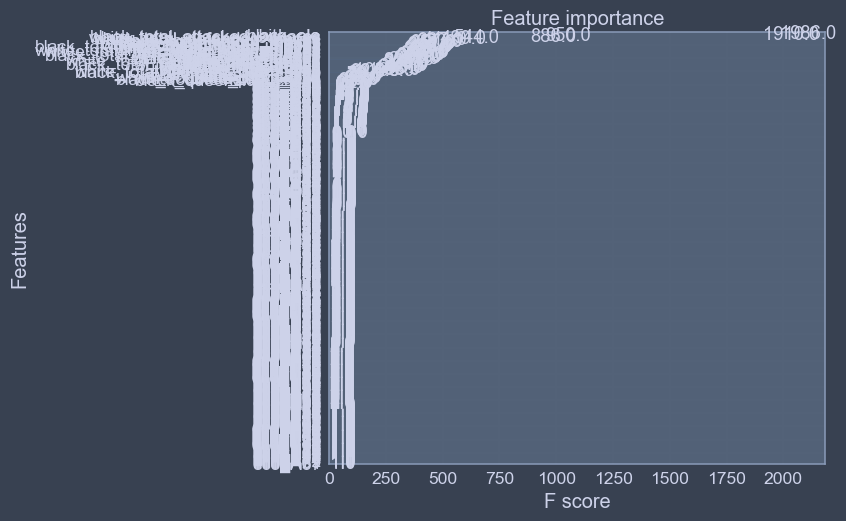

In [120]:
xgb.plot_importance(xgb_model2_eco)
plt.tight_layout

In [159]:
X_train6 = X_train[['white_elo','black_elo']]
X_test6 = X_test[['white_elo','black_elo']]

In [160]:
xgb_model6 = xgb.XGBClassifier(n_estimators=1000,early_stopping_rounds=50)
xgb_model6.fit(X_train6,y_train,
              eval_set=[(X_train6,y_train),(X_test6,y_test)],
              verbose=True
             )
xgb_pred6 = pd.Series(xgb_model6.predict(X_test6))
report_performance(y_test,xgb_pred6)

[0]	validation_0-logloss:0.66106	validation_1-logloss:0.66102
[1]	validation_0-logloss:0.64308	validation_1-logloss:0.64308
[2]	validation_0-logloss:0.63284	validation_1-logloss:0.63285
[3]	validation_0-logloss:0.62680	validation_1-logloss:0.62681
[4]	validation_0-logloss:0.62320	validation_1-logloss:0.62324
[5]	validation_0-logloss:0.62106	validation_1-logloss:0.62114
[6]	validation_0-logloss:0.61972	validation_1-logloss:0.61983
[7]	validation_0-logloss:0.61886	validation_1-logloss:0.61900
[8]	validation_0-logloss:0.61841	validation_1-logloss:0.61857
[9]	validation_0-logloss:0.61806	validation_1-logloss:0.61823
[10]	validation_0-logloss:0.61782	validation_1-logloss:0.61803
[11]	validation_0-logloss:0.61768	validation_1-logloss:0.61791
[12]	validation_0-logloss:0.61756	validation_1-logloss:0.61781
[13]	validation_0-logloss:0.61750	validation_1-logloss:0.61776
[14]	validation_0-logloss:0.61745	validation_1-logloss:0.61773
[15]	validation_0-logloss:0.61741	validation_1-logloss:0.61770
[1

In [161]:
xgb_pred6 = pd.Series(xgb_model6.predict(X_test6))
report_performance(y_test_eco,xgb_pred6)

Accuracy: 0.65, F1: 0.65
Precision: 0.65, Recall: 0.65
Confusion Matrix:
[[246821 135503]
 [132896 249850]]


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

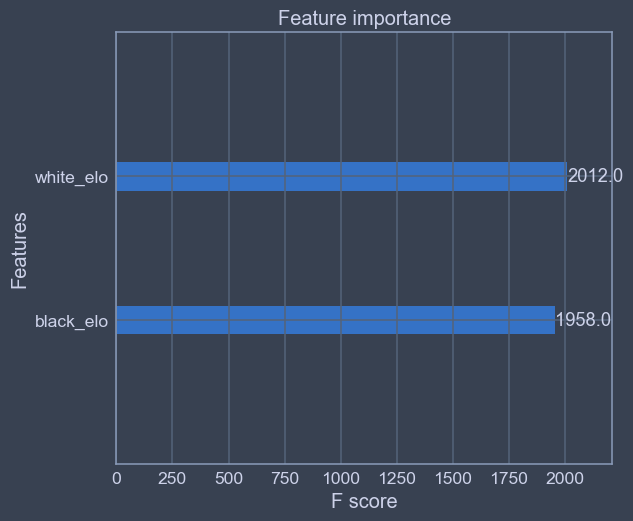

In [162]:
xgb.plot_importance(xgb_model6)

In [182]:
cv_params1 =  {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6, 7]
}

xgb_cv_model1 = xgb.XGBClassifier(n_estimators=5000,early_stopping_rounds=50)
xgb_cv1 = GridSearchCV(
    xgb_cv_model1, 
    cv_params1, 
    scoring='accuracy', 
    cv=3,
    verbose=3
)
xgb_cv1.fit(X_train3,y_train,
            verbose=False,
            eval_set=[(X_train3,y_train),(X_test3,y_test)]
           )

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END ...learning_rate=0.01, max_depth=3;, score=0.686 total time=29.1min
[CV 2/3] END ...learning_rate=0.01, max_depth=3;, score=0.686 total time=26.5min
[CV 3/3] END ...learning_rate=0.01, max_depth=3;, score=0.685 total time=25.4min
[CV 1/3] END ...learning_rate=0.01, max_depth=4;, score=0.687 total time=30.2min
[CV 2/3] END ...learning_rate=0.01, max_depth=4;, score=0.687 total time=30.1min
[CV 3/3] END ...learning_rate=0.01, max_depth=4;, score=0.686 total time=30.4min
[CV 1/3] END ...learning_rate=0.01, max_depth=5;, score=0.687 total time=35.9min
[CV 2/3] END ...learning_rate=0.01, max_depth=5;, score=0.687 total time=36.0min
[CV 3/3] END ...learning_rate=0.01, max_depth=5;, score=0.687 total time=35.4min
[CV 1/3] END ...learning_rate=0.01, max_depth=6;, score=0.687 total time=39.9min
[CV 2/3] END ...learning_rate=0.01, max_depth=6;, score=0.687 total time=40.3min
[CV 3/3] END ...learning_rate=0.01, max_depth=6;

KeyboardInterrupt: 

In [ ]:
xbg_cv1_pred = pd.Series(xgb_cv1.predict(X_test3))
report_performance(y_test,xbg_cv1_pred)
xgb.plot_importance(xbg_cv1_pred)

In [ ]:
print(xgb_cv1.best_params_)
print(xgb_cv1.cv_results_)

In [ ]:
df[df.isna().any(axis=1)].head(20)

In [15]:
logistic_regression_model = LogisticRegression(max_iter=500).fit(X_train3,y_train)
logistic_regression_pred = logistic_regression_model.predict(X_test3)
report_performance(y_test,logistic_regression_pred)

C:\Users\alexpc2red\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6875, F1: 0.6886
Precision: 0.6878, Recall: 0.6894
Confusion Matrix:
[[260833 119633]
 [118739 263604]]


In [1]:
logistic_regression_cv_model = LogisticRegressionCV(max_iter=500,solver='saga',penalty='elasticnet',l1_ratios=[0,0.01,0.1,1.0]).fit(X_train1,y_train)
logistic_regression_cv_pred = logistic_regression_cv_model.predict(X_test1)
report_performance(y_test,logistic_regression_cv_pred)

NameError: name 'LogisticRegressionCV' is not defined